In [146]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.optimize as opt
%matplotlib inline

class many_weight_linear_model():
    def __init__(self, method='svm', delta=0.5, lmda=0.5):
        self.delta = delta
        self.lmda = lmda
        self.method = method
        self.W = None
        self.N, self.M, self.D = None, None, None
        self.v, self.m, self.t = None, None, None
        self.learning_rate, self.eps, self.beta_1, self.beta_2 = 1e-2, 1e-8, 0.9, 0.999
        
    def prepare_data(self, X, y):
        X = np.array(X)
        y = np.array(y).astype(int)
        X = np.concatenate((X, np.ones([X.shape[0], 1])), axis=1)
        self.N = X.shape[0]
        self.D = X.shape[1]
        self.M = np.unique(y).shape[0]
        self.W = np.random.randn(X.shape[1], np.max(y) + 1) / np.sqrt(X.shape[1] / 2)
        self.t = 0
        self.m = np.zeros(self.W.shape)
        self.v = np.zeros(self.W.shape)
        return X, y

    def predict(self, X):
        X = np.concatenate((X, np.ones([X.shape[0],1])), axis=1)
        scores = X.dot(self.W)
        return np.argmax(scores, axis=1)
    
    def loss_and_grad_softmax(self, X, y):
        scores = X.dot(self.W)
        scores -= np.max(scores, axis=1, keepdims=True)
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        correct_logprobs = - np.log(probs[np.arange(X.shape[0]), y])
        loss = np.sum(correct_logprobs) + self.lmda * np.sum(self.W * self.W)
        
        dscores = probs
        dscores[np.arange(X.shape[0]), y] -= 1
        dscores /= X.shape[0]
        dW = np.dot(X.T, dscores) + self.lmda * 2 * self.W
        
        return loss, dW
    
    def loss_and_grad_svm(self, X, y):
        scores = X.dot(self.W)
        right_scores = scores[np.arange(self.N), y].reshape([self.N, 1])
        margins = np.maximum(0, scores - right_scores + self.delta)
        margins[np.arange(self.N), y] = 0
        loss = np.sum(margins) / self.N + self.lmda * np.sum(self.W * self.W)
        
        margins = margins > 0
        to_minus = np.sum(margins, axis=1)
        coefs_0 = ((margins[:, 0] > 0) - to_minus * (y == 0)).reshape([self.N, 1])
        derivatives = np.sum(X * coefs_0, axis=0)
        derivatives = derivatives.reshape([1, self.D])
        for i in np.arange(1, self.M):
            coefs_i = ((margins[:, i] > 0) - to_minus * (y == i)).reshape([self.N, 1])
            derivatives = np.concatenate((derivatives, [np.sum(X * coefs_i, axis=0)]))
        dW = derivatives.T / self.N + 2 * self.lmda * self.W
        
        return loss, dW
    
    def loss_and_grad(self, X, y):
        if self.method == 'softmax':
            return self.loss_and_grad_softmax(X, y)
        else:
            return self.loss_and_grad_svm(X, y)
    
    def adam(self, X, y):
        loss, dW = self.loss_and_grad(X, y)
        self.t += 1
        self.m = self.m * self.beta_1 + (1 - self.beta_1) * dW
        self.v = self.v * self.beta_2 + (1 - self.beta_2) * dW * dW
        
        m = self.m / (1 - self.beta_1 ** self.t)
        v = self.v / (1 - self.beta_2 ** self.t)
        self.W -= self.learning_rate * self.m / (np.sqrt(self.v) + self.eps)
    
    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        for step in range(1000):
            l = self.adam(X, y)

In [147]:
def plot_on_plane(obj, labels, alpha=1, s=75):
    x = y = np.arange(np.min(obj) - 1, np.max(obj) + 1, 0.01)
    X, Y = np.meshgrid(x, y)
    
    objects = np.stack((X, Y), axis=-1).reshape([X.shape[0] * X.shape[1], 2])
    print(objects.shape)
    Z = lm.predict(objects).reshape(X.shape)

    cmap = colors.ListedColormap(['green', 'yellow'])
    plt.contourf(X, Y, Z, cmap=cmap, alpha=alpha)
    plt.scatter(obj[:, 0], obj[:, 1], c = labels, s=s)
    plt.show()

(360000, 2)


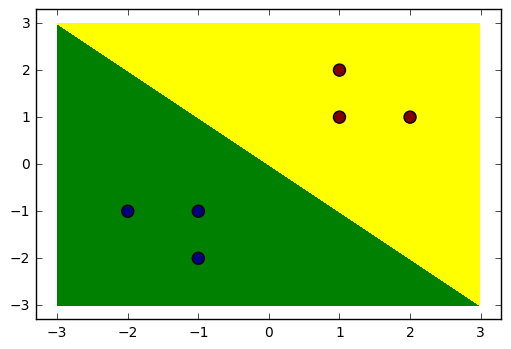

In [150]:
x = np.array([[-1, -1], [-1, -2], [-2, -1], [1 ,1], [1, 2], [2, 1]])
y = np.array([0,0,0,1,1,1])

lm = many_weight_linear_model(method='svm')
lm.fit(x, y)

plot_on_plane(x, y)

(525625, 2)


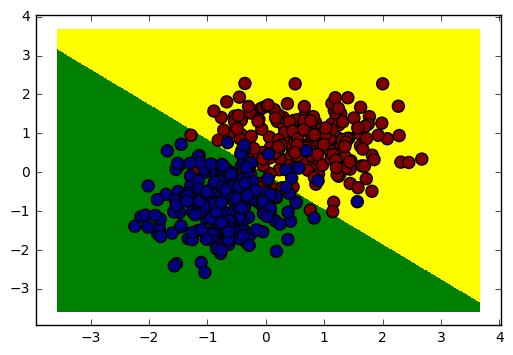

0.9325 % is accuracy
CPU times: user 524 ms, sys: 304 ms, total: 828 ms
Wall time: 477 ms


In [151]:
%%time
X = np.concatenate([np.random.normal(loc=0.7, scale=0.7, size=[200, 2]),
                    np.random.normal(loc=-0.7, scale=0.7, size=[200, 2])])
y = np.concatenate([np.ones(200),
                    np.zeros(200)])
lm = many_weight_linear_model(method='svm')
lm.fit(X, y)
plot_on_plane(X, y)
print(np.sum(lm.predict(X) == y) / 400, '% is accuracy')